In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd '/content/drive/MyDrive/phase4 public'
!ls

/content/drive/.shortcut-targets-by-id/1olR9djsPqRY8dxn01k2qeMnqfOfqWRQE/phase4 public
'CI - Spring_2023 - phase4.pdf'   exploring_data.py   utils.py
 data				  __pycache__
 dataloader_demo.ipynb		  triplet_loss.py


In [3]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.functional import F
from tqdm import trange
import numpy as np
from tqdm import trange

model definition

In [59]:
class demo_model(nn.Module):
    def __init__(self) -> None:
        super().__init__()

        # define layers
        # parameters are defined here
        self.conv1 = nn.Conv2d(3, 6, 5, padding=2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1   = nn.Linear(16*6*6, 256)
        self.fc2   = nn.Linear(512, 240)
        self.fc3   = nn.Linear(240, 160)
        self.fc4   = nn.Linear(160, 10)
    # Forward Pass
    def forward(self, images, features):
        # [N, 1, 28, 28]
        # You can use any of the Tensor operations in the forward function.
        # 3 * 32 * 32
        x = F.max_pool2d(F.relu(self.conv1(images)), (2, 2))
        # 6 * 16 * 16
        x = F.max_pool2d(F.relu(self.conv2(x)), (2, 2))
        # 16 * 6 * 6
        x = x.view(-1, self.num_flat_features(x))
        # f1 without rlue
        x = self.fc1(x)
        x =  torch.cat((x, features), dim=1)
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x
    def num_flat_features(self, x):
        '''
        Get the number of features in a batch of tensors `x`.
        '''
        size = x.size()[1:]
        return np.prod(size)

In [60]:
def train_one_epoch(model: nn.Module, optim: torch.optim.Optimizer, dataloader: DataLoader, loss_fn):

    # utils
    num_samples = len(dataloader.dataset)
    num_batches = len(dataloader)
    running_corrects = 0
    running_loss = 0.0
    model.train() #
    for batch_indx, (images, features, domain_labels, digit_labels) in enumerate(dataloader): # Get a batch of Data

        outputs = model(images, features) # Forward Pass, [N, 10]
        loss = loss_fn(outputs, digit_labels) # Compute Loss

        loss.backward() # Compute Gradients
        optim.step() # Update parameters
        optim.zero_grad() # zero the parameter's gradients

        _, preds = torch.max(outputs, dim=1) # Explain, [N]
        running_corrects += torch.sum(preds == digit_labels)
        running_loss += loss.item()

    epoch_acc = (running_corrects / num_samples) * 100
    epoch_loss = (running_loss / num_batches)

    return epoch_acc, epoch_loss

In [61]:
def test_model(model: nn.Module, dataloader: DataLoader, loss_fn):
    num_samples = len(dataloader.dataset)
    num_batches = len(dataloader)
    running_corrects = 0
    running_loss = 0.0
    model.eval()
    with torch.no_grad():
        for batch_indx, (images, features, domain_labels, digit_labels) in enumerate(dataloader):
            outputs = model(images, features)
            loss = loss_fn(outputs, digit_labels)
            _, preds = torch.max(outputs, 1)
            running_corrects += torch.sum(preds == digit_labels)
            running_loss += loss.item()
    test_acc = (running_corrects / num_samples) * 100
    test_loss = (running_loss / num_batches)
    return test_acc, test_loss

In [ ]:
from utils import custom_plot_training_stats
from utils import get_data_loaders

def loaders_demo(lrate, bs):
    num_epochs = 10
    learning_rate = lrate
    full_dataloaders, _ = get_data_loaders(
        filenames={
            'train': './data/12000_train_mnistmnistmsvhnsynusps.npz',
            'test': './data/12000_test_mnistmnistmsvhnsynusps.npz',
        },
        batch_size= bs

    )
    model = demo_model()
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    cross_entropy = nn.CrossEntropyLoss()
    acc_history = {'train': [], 'test': []}
    loss_history = {'train': [], 'test': []}

    for epoch in trange(num_epochs):
        train_acc, train_loss = train_one_epoch(model=model, optim=optimizer, dataloader=full_dataloaders['train'] , loss_fn=cross_entropy)
        test_acc, test_loss = test_model(model=model, dataloader=full_dataloaders['test'], loss_fn=cross_entropy)

        acc_history['train'].append(train_acc)
        acc_history['test'].append(test_acc)
        loss_history['train'].append(train_loss)
        loss_history['test'].append(test_loss)
    #custom_plot_training_stats(acc_history, loss_history, ['train', 'test'], title='demp', dir='demo_plots')
    print("train acc: " )
    print( str(acc_history['train'][9]));
    print("test acc: ")
    print( str(acc_history['test'][9]));

find best combination for learning rate and batch size

In [ ]:
for i in [0.02, 0.025, 0.03, 0.035]:
  for j in [16, 32, 64]:
    print("*******************************************************************************************")
    print("Learning Rate: " + str(i) + "\tBatch Size: " + str(j))
    loaders_demo(i, j)

*******************************************************************************************
Learning Rate: 0.02	Batch Size: 16
datafiles to read:  {'train': './data/12000_train_mnistmnistmsvhnsynusps.npz', 'test': './data/12000_test_mnistmnistmsvhnsynusps.npz'}
reading ./data/12000_train_mnistmnistmsvhnsynusps.npz, number of samples: 60000
reading ./data/12000_test_mnistmnistmsvhnsynusps.npz, number of samples: 21600
reading ./data/12000_test_mnistmnistmsvhnsynusps.npz, number of samples: 21600


100%|██████████| 10/10 [05:16<00:00, 31.63s/it]


train acc: 
tensor(96.2083)
test acc: 
tensor(92.1296)
*******************************************************************************************
Learning Rate: 0.02	Batch Size: 32
datafiles to read:  {'train': './data/12000_train_mnistmnistmsvhnsynusps.npz', 'test': './data/12000_test_mnistmnistmsvhnsynusps.npz'}
reading ./data/12000_train_mnistmnistmsvhnsynusps.npz, number of samples: 60000
reading ./data/12000_test_mnistmnistmsvhnsynusps.npz, number of samples: 21600
reading ./data/12000_test_mnistmnistmsvhnsynusps.npz, number of samples: 21600


100%|██████████| 10/10 [04:32<00:00, 27.28s/it]


train acc: 
tensor(95.3567)
test acc: 
tensor(91.9537)
*******************************************************************************************
Learning Rate: 0.02	Batch Size: 64
datafiles to read:  {'train': './data/12000_train_mnistmnistmsvhnsynusps.npz', 'test': './data/12000_test_mnistmnistmsvhnsynusps.npz'}
reading ./data/12000_train_mnistmnistmsvhnsynusps.npz, number of samples: 60000
reading ./data/12000_test_mnistmnistmsvhnsynusps.npz, number of samples: 21600
reading ./data/12000_test_mnistmnistmsvhnsynusps.npz, number of samples: 21600


100%|██████████| 10/10 [04:10<00:00, 25.08s/it]


train acc: 
tensor(93.2517)
test acc: 
tensor(90.9306)
*******************************************************************************************
Learning Rate: 0.025	Batch Size: 16
datafiles to read:  {'train': './data/12000_train_mnistmnistmsvhnsynusps.npz', 'test': './data/12000_test_mnistmnistmsvhnsynusps.npz'}
reading ./data/12000_train_mnistmnistmsvhnsynusps.npz, number of samples: 60000
reading ./data/12000_test_mnistmnistmsvhnsynusps.npz, number of samples: 21600
reading ./data/12000_test_mnistmnistmsvhnsynusps.npz, number of samples: 21600


100%|██████████| 10/10 [05:14<00:00, 31.41s/it]


train acc: 
tensor(96.3417)
test acc: 
tensor(92.4491)
*******************************************************************************************
Learning Rate: 0.025	Batch Size: 32
datafiles to read:  {'train': './data/12000_train_mnistmnistmsvhnsynusps.npz', 'test': './data/12000_test_mnistmnistmsvhnsynusps.npz'}
reading ./data/12000_train_mnistmnistmsvhnsynusps.npz, number of samples: 60000
reading ./data/12000_test_mnistmnistmsvhnsynusps.npz, number of samples: 21600
reading ./data/12000_test_mnistmnistmsvhnsynusps.npz, number of samples: 21600


100%|██████████| 10/10 [04:32<00:00, 27.28s/it]


train acc: 
tensor(95.8533)
test acc: 
tensor(92.0509)
*******************************************************************************************
Learning Rate: 0.025	Batch Size: 64
datafiles to read:  {'train': './data/12000_train_mnistmnistmsvhnsynusps.npz', 'test': './data/12000_test_mnistmnistmsvhnsynusps.npz'}
reading ./data/12000_train_mnistmnistmsvhnsynusps.npz, number of samples: 60000
reading ./data/12000_test_mnistmnistmsvhnsynusps.npz, number of samples: 21600
reading ./data/12000_test_mnistmnistmsvhnsynusps.npz, number of samples: 21600


100%|██████████| 10/10 [04:09<00:00, 24.91s/it]


train acc: 
tensor(94.1217)
test acc: 
tensor(91.4444)
*******************************************************************************************
Learning Rate: 0.03	Batch Size: 16
datafiles to read:  {'train': './data/12000_train_mnistmnistmsvhnsynusps.npz', 'test': './data/12000_test_mnistmnistmsvhnsynusps.npz'}
reading ./data/12000_train_mnistmnistmsvhnsynusps.npz, number of samples: 60000
reading ./data/12000_test_mnistmnistmsvhnsynusps.npz, number of samples: 21600
reading ./data/12000_test_mnistmnistmsvhnsynusps.npz, number of samples: 21600


100%|██████████| 10/10 [05:15<00:00, 31.53s/it]


train acc: 
tensor(96.2100)
test acc: 
tensor(92.5278)
*******************************************************************************************
Learning Rate: 0.03	Batch Size: 32
datafiles to read:  {'train': './data/12000_train_mnistmnistmsvhnsynusps.npz', 'test': './data/12000_test_mnistmnistmsvhnsynusps.npz'}
reading ./data/12000_train_mnistmnistmsvhnsynusps.npz, number of samples: 60000
reading ./data/12000_test_mnistmnistmsvhnsynusps.npz, number of samples: 21600
reading ./data/12000_test_mnistmnistmsvhnsynusps.npz, number of samples: 21600


100%|██████████| 10/10 [04:32<00:00, 27.22s/it]


train acc: 
tensor(96.1183)
test acc: 
tensor(92.1574)
*******************************************************************************************
Learning Rate: 0.03	Batch Size: 64
datafiles to read:  {'train': './data/12000_train_mnistmnistmsvhnsynusps.npz', 'test': './data/12000_test_mnistmnistmsvhnsynusps.npz'}
reading ./data/12000_train_mnistmnistmsvhnsynusps.npz, number of samples: 60000
reading ./data/12000_test_mnistmnistmsvhnsynusps.npz, number of samples: 21600
reading ./data/12000_test_mnistmnistmsvhnsynusps.npz, number of samples: 21600


100%|██████████| 10/10 [04:10<00:00, 25.09s/it]


train acc: 
tensor(94.7083)
test acc: 
tensor(91.7917)
*******************************************************************************************
Learning Rate: 0.035	Batch Size: 16
datafiles to read:  {'train': './data/12000_train_mnistmnistmsvhnsynusps.npz', 'test': './data/12000_test_mnistmnistmsvhnsynusps.npz'}
reading ./data/12000_train_mnistmnistmsvhnsynusps.npz, number of samples: 60000
reading ./data/12000_test_mnistmnistmsvhnsynusps.npz, number of samples: 21600
reading ./data/12000_test_mnistmnistmsvhnsynusps.npz, number of samples: 21600


100%|██████████| 10/10 [05:34<00:00, 33.43s/it]


train acc: 
tensor(96.0750)
test acc: 
tensor(92.1204)
*******************************************************************************************
Learning Rate: 0.035	Batch Size: 32
datafiles to read:  {'train': './data/12000_train_mnistmnistmsvhnsynusps.npz', 'test': './data/12000_test_mnistmnistmsvhnsynusps.npz'}
reading ./data/12000_train_mnistmnistmsvhnsynusps.npz, number of samples: 60000
reading ./data/12000_test_mnistmnistmsvhnsynusps.npz, number of samples: 21600
reading ./data/12000_test_mnistmnistmsvhnsynusps.npz, number of samples: 21600


100%|██████████| 10/10 [04:34<00:00, 27.46s/it]


train acc: 
tensor(96.1033)
test acc: 
tensor(91.3796)
*******************************************************************************************
Learning Rate: 0.035	Batch Size: 64
datafiles to read:  {'train': './data/12000_train_mnistmnistmsvhnsynusps.npz', 'test': './data/12000_test_mnistmnistmsvhnsynusps.npz'}
reading ./data/12000_train_mnistmnistmsvhnsynusps.npz, number of samples: 60000
reading ./data/12000_test_mnistmnistmsvhnsynusps.npz, number of samples: 21600
reading ./data/12000_test_mnistmnistmsvhnsynusps.npz, number of samples: 21600


100%|██████████| 10/10 [04:11<00:00, 25.13s/it]

train acc: 
tensor(95.0150)
test acc: 
tensor(91.6389)


In [ ]:
from utils import custom_plot_training_stats
from utils import get_data_loaders

def loaders_demoNP():
    num_epochs = 10
    full_dataloaders, _ = get_data_loaders(
        filenames={
            'train': './data/12000_train_mnistmnistmsvhnsynusps.npz',
            'test': './data/12000_test_mnistmnistmsvhnsynusps.npz',
        },
        batch_size= 16

    )
    print(full_dataloaders.keys())
    model = demo_model()
    optimizer1 = torch.optim.SGD(model.parameters(), lr=0.028)
    optimizer2 = torch.optim.SGD(model.parameters(), lr=0.023)
    cross_entropy = nn.CrossEntropyLoss()
    acc_history = {'train': [], 'test': []}
    loss_history = {'train': [], 'test': []}
    i = 0;
    for epoch in trange(num_epochs):
        i += 1
        if(i < 6):
          train_acc, train_loss = train_one_epoch(model=model, optim=optimizer1, dataloader=full_dataloaders['train'] , loss_fn=cross_entropy)
        else:
          train_acc, train_loss = train_one_epoch(model=model, optim=optimizer2, dataloader=full_dataloaders['train'] , loss_fn=cross_entropy)
        test_acc, test_loss = test_model(model=model, dataloader=full_dataloaders['test'], loss_fn=cross_entropy)

        acc_history['train'].append(train_acc)
        acc_history['test'].append(test_acc)
        loss_history['train'].append(train_loss)
        loss_history['test'].append(test_loss)

    custom_plot_training_stats(acc_history, loss_history, ['train', 'test'], title='demp', dir='demo_plots')
    print("train acc: " )
    print( str(acc_history['train'][9]));
    print("test acc: ")
    print( str(acc_history['test'][9]));

model with dynamic learning rate

datafiles to read:  {'train': './data/12000_train_mnistmnistmsvhnsynusps.npz', 'test': './data/12000_test_mnistmnistmsvhnsynusps.npz'}
reading ./data/12000_train_mnistmnistmsvhnsynusps.npz, number of samples: 60000
reading ./data/12000_test_mnistmnistmsvhnsynusps.npz, number of samples: 21600
reading ./data/12000_test_mnistmnistmsvhnsynusps.npz, number of samples: 21600
dict_keys(['train', 'test', 'test_missing', 'train_size', 'test_size', 'test_missing_size'])


100%|██████████| 10/10 [05:23<00:00, 32.32s/it]


OSError: ignored

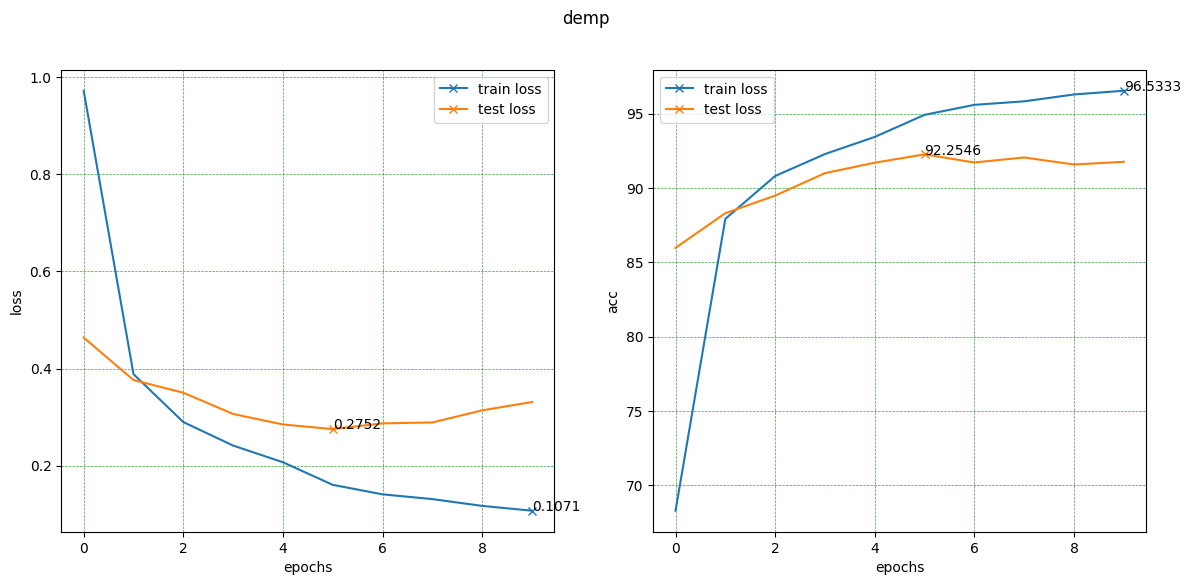

In [ ]:
loaders_demoNP()

In [ ]:
from utils import custom_plot_training_stats
from utils import get_data_loaders

def final():
    num_epochs = 10
    full_dataloaders, _ = get_data_loaders(
        filenames={
            'train': './data/12000_train_mnistmnistmsvhnsynusps.npz',
            'test': './data/12000_test_mnistmnistmsvhnsynusps.npz',
        },
        batch_size= 16

    )
    print(full_dataloaders.keys())
    model = demo_model()
    optimizer1 = torch.optim.SGD(model.parameters(), lr=0.025)
    cross_entropy = nn.CrossEntropyLoss()
    acc_history = {'train': [], 'test': []}
    loss_history = {'train': [], 'test': []}
    for epoch in trange(num_epochs):

       train_acc, train_loss = train_one_epoch(model=model, optim=optimizer1, dataloader=full_dataloaders['train'] , loss_fn=cross_entropy)
       test_acc, test_loss = test_model(model=model, dataloader=full_dataloaders['test'], loss_fn=cross_entropy)

       acc_history['train'].append(train_acc)
       acc_history['test'].append(test_acc)
       loss_history['train'].append(train_loss)
       loss_history['test'].append(test_loss)
    print("train acc: " )
    print( str(acc_history['train'][9]));
    print("test acc: ")
    print( str(acc_history['test'][9]));
    custom_plot_training_stats(acc_history, loss_history, ['train', 'test'], title='demp', dir='demo_plots')


model for test

datafiles to read:  {'train': './data/12000_train_mnistmnistmsvhnsynusps.npz', 'test': './data/12000_test_mnistmnistmsvhnsynusps.npz'}
reading ./data/12000_train_mnistmnistmsvhnsynusps.npz, number of samples: 60000
reading ./data/12000_test_mnistmnistmsvhnsynusps.npz, number of samples: 21600
reading ./data/12000_test_mnistmnistmsvhnsynusps.npz, number of samples: 21600
dict_keys(['train', 'test', 'test_missing', 'train_size', 'test_size', 'test_missing_size'])


100%|██████████| 10/10 [05:24<00:00, 32.49s/it]

train acc: 
tensor(96.3417)
test acc: 
tensor(92.4491)


OSError: ignored

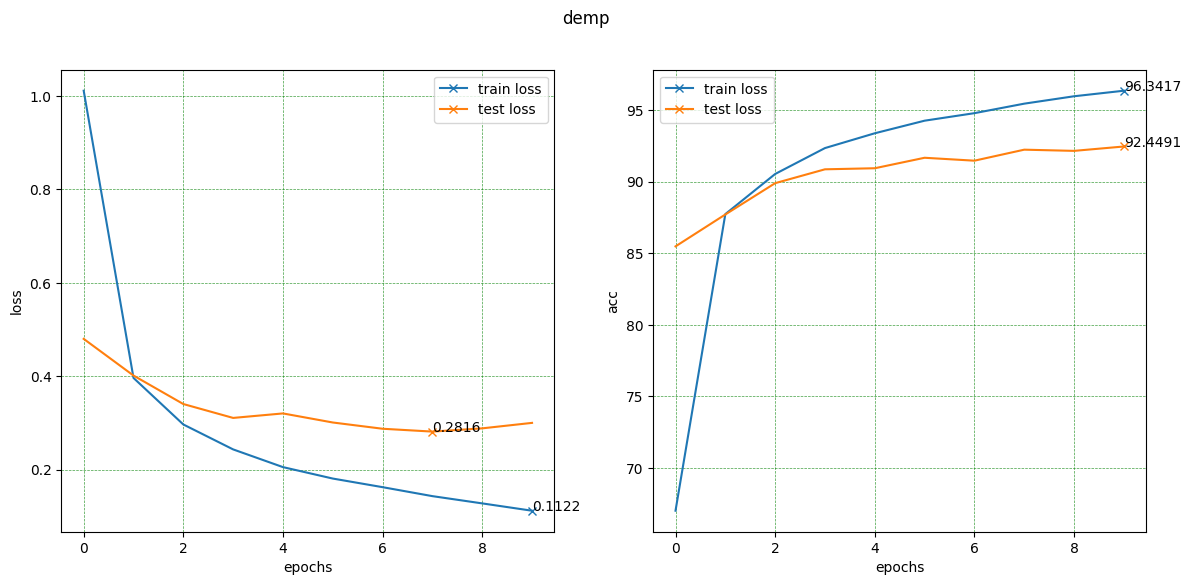

In [ ]:
final()

In [62]:
from utils import custom_plot_training_stats
from utils import get_data_loaders

def final():
    num_epochs = 10
    full_dataloaders, _ = get_data_loaders(
        filenames={
            'train': './data/12000_train_mnistmnistmsvhnsynusps.npz',
            'test': './data/12000_test_mnistmnistmsvhnsynusps.npz',
        },
        batch_size= 16

    )
    print(full_dataloaders.keys())
    model = demo_model()
    optimizer1 = torch.optim.SGD(model.parameters(), lr=0.025)
    cross_entropy = nn.CrossEntropyLoss()
    acc_history = {'train': [], 'test_missing': []}
    loss_history = {'train': [], 'test_missing': []}
    for epoch in trange(num_epochs):

       train_acc, train_loss = train_one_epoch(model=model, optim=optimizer1, dataloader=full_dataloaders['train'] , loss_fn=cross_entropy)
       test_acc, test_loss = test_model(model=model, dataloader=full_dataloaders['test_missing'], loss_fn=cross_entropy)

       acc_history['train'].append(train_acc)
       acc_history['test_missing'].append(test_acc)
       loss_history['train'].append(train_loss)
       loss_history['test_missing'].append(test_loss)
    print("train acc: " )
    print( str(acc_history['train'][9]));
    print("test_missing acc: ")
    print( str(acc_history['test_missing'][9]));
    custom_plot_training_stats(acc_history, loss_history, ['train', 'test_missing'], title='demp', dir='demo_plots')


model for test_missing

datafiles to read:  {'train': './data/12000_train_mnistmnistmsvhnsynusps.npz', 'test': './data/12000_test_mnistmnistmsvhnsynusps.npz'}
reading ./data/12000_train_mnistmnistmsvhnsynusps.npz, number of samples: 60000
reading ./data/12000_test_mnistmnistmsvhnsynusps.npz, number of samples: 21600
reading ./data/12000_test_mnistmnistmsvhnsynusps.npz, number of samples: 21600
dict_keys(['train', 'test', 'test_missing', 'train_size', 'test_size', 'test_missing_size'])


100%|██████████| 10/10 [06:28<00:00, 38.86s/it]

train acc: 
tensor(96.3417)
test_missing acc: 
tensor(90.3333)


OSError: ignored

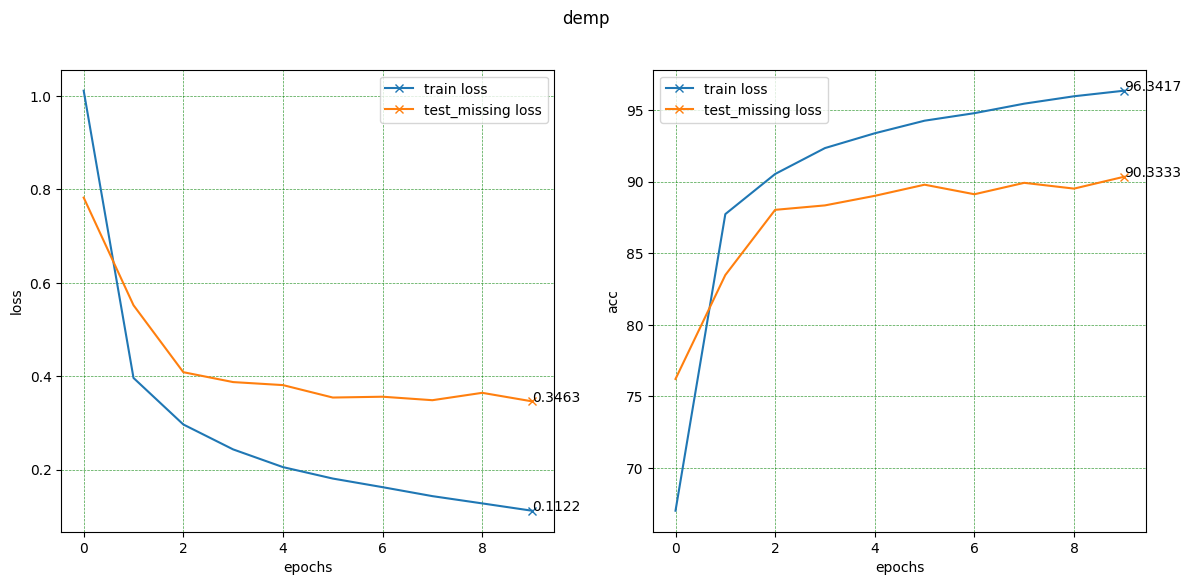

In [63]:
final()

with tripletLoss

In [ ]:
from utils import custom_plot_training_stats
from utils import get_data_loaders
class demo_model(nn.Module):
    def __init__(self) -> None:
        super().__init__()

        # define layers
        # parameters are defined here
        self.conv1 = nn.Conv2d(3, 6, 5, padding=2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1   = nn.Linear(16*6*6, 256)
        self.fc2   = nn.Linear(512, 240)
        self.fc3   = nn.Linear(240, 160)
        self.fc4   = nn.Linear(160, 10)
    # Forward Pass
    def forward(self, images, features):

        # 3 * 32 * 32
        x = F.max_pool2d(F.relu(self.conv1(images)), (2, 2))
        # 6 * 16 * 16
        x = F.max_pool2d(F.relu(self.conv2(x)), (2, 2))
        # 16 * 6 * 6
        x = x.view(-1, self.num_flat_features(x))
        # f1 without rlue
        x = self.fc1(x)
        x =  torch.cat((x, features), dim=1)
        baz = F.relu(self.fc2(x))
        x = F.relu(self.fc3(baz))
        x = self.fc4(x)
        return baz, x
    def num_flat_features(self, x):
        '''
        Get the number of features in a batch of tensors `x`.
        '''
        size = x.size()[1:]
        return np.prod(size)

class tripletLoss(nn.Module):
    def __init__(self, margin: float = 0.005, device = torch.device('cpu')) -> None:
        super().__init__()

        self.margin = torch.tensor(margin)
        self.device = device


    def forward(self, embeddings, labels):
        dp, dn = self.batch_hard_triplet_loss(embeddings, labels)
        triplet_loss = torch.mean(torch.clamp(dp - dn + self.margin, min=0))
        return triplet_loss

    def batch_hard_triplet_loss(self, embeddings, labels):


        dists = self.euclidean_dist(embeddings, embeddings)
        same_identity_mask = torch.eq(labels[:, None], labels[None, :])
        negative_mask = torch.logical_not(same_identity_mask)
        positive_mask = torch.logical_xor(same_identity_mask, torch.eye(labels.shape[0], dtype=torch.bool).to(self.device))
        dp, _ = torch.max(dists * (positive_mask.int()), dim=1)
        dn = torch.zeros_like(dp)
        for i in range(dists.shape[0]):
            dn[i] = torch.min(dists[i, :][negative_mask[i, :]])
        return dp, dn

    def all_diffs(self, a, b):
        # a, b -> [N, d]
        # return -> [N, N, d]
        return a[:, None] - b[None, :]

    def euclidean_dist(self, embed1, embed2):
        diffs = self.all_diffs(embed1, embed2)
        t1 = torch.square(diffs)
        t2 = torch.sum(t1, dim=-1)
        return torch.sqrt(t2 + 1e-12)

def train_one_epoch(model: nn.Module, optim: torch.optim.Optimizer, dataloader: DataLoader, loss_fn, triplet_loss , l):

    num_samples = len(dataloader.dataset)
    num_batches = len(dataloader)
    running_corrects = 0
    running_loss = 0.0
    running_lossCE = 0.0
    running_lossTr = 0.0
    model.train()
    for batch_indx, (images, features, domain_labels, digit_labels) in enumerate(dataloader): # Get a batch of Data

        baz,outputs = model(images, features) # Forward Pass, [N, 10]
        lossCE = loss_fn(outputs, digit_labels) # Compute Loss
        lossTr = triplet_loss(baz, domain_labels)
        loss = lossCE + l * lossTr
        loss.backward() # Compute Gradients
        optim.step() # Update parameters
        optim.zero_grad() # zero the parameter's gradients

        _, preds = torch.max(outputs, dim=1) # Explain, [N]
        running_corrects += torch.sum(preds == digit_labels)
        running_loss += loss.item()
        running_lossCE += lossCE.item()
        running_lossTr += lossTr.item()

    epoch_acc = (running_corrects / num_samples) * 100
    epoch_lossCE = (running_lossCE / num_batches)
    epoch_lossTr = (running_lossTr / num_batches)
    epoch_loss = (running_loss / num_batches)

    return epoch_acc, epoch_lossCE, epoch_lossTr, epoch_loss

def test_model(model: nn.Module, dataloader: DataLoader, loss_fn, triplet_loss, l):
    num_samples = len(dataloader.dataset)
    num_batches = len(dataloader)
    running_corrects = 0
    running_loss = 0.0
    running_lossCE = 0.0
    running_lossTr = 0.0
    model.eval()
    with torch.no_grad():
        for batch_indx, (images, features, domain_labels, digit_labels) in enumerate(dataloader):
            baz, outputs = model(images, features)
            lossCE = loss_fn(outputs, digit_labels)
            lossTr = triplet_loss(baz, domain_labels)
            loss = lossCE + l * lossTr
            _, preds = torch.max(outputs, 1)
            running_corrects += torch.sum(preds == digit_labels)
            running_lossCE += lossCE.item()
            running_lossTr += lossTr.item()
            running_loss += loss.item()
    test_acc = (running_corrects / num_samples) * 100
    test_lossCE = (running_lossCE / num_batches)
    test_lossTr = (running_lossTr / num_batches)
    test_loss = (running_loss / num_batches)
    return test_acc, test_lossCE, test_lossTr, test_loss

def example(lam):
    num_epochs = 10
    full_dataloaders, _ = get_data_loaders(
        filenames={
            'train': './data/12000_train_mnistmnistmsvhnsynusps.npz',
            'test': './data/12000_test_mnistmnistmsvhnsynusps.npz',
        },
        batch_size= 16

    )
    model = demo_model()
    optimizer1 = torch.optim.SGD(model.parameters(), lr=0.025)
    cross_entropy = nn.CrossEntropyLoss()
    triplet_loss = tripletLoss(margin=0.005)
    acc_history = {'train': [], 'test': []}
    lossCE_history = {'train': [], 'test': []}
    lossTr_history = {'train': [], 'test': []}
    loss_history = {'train': [], 'test': []}
    l = lam
    for epoch in trange(num_epochs):

        train_acc, train_lossCE, train_lossTr, train_loss = train_one_epoch(model=model, optim=optimizer1, dataloader=full_dataloaders['train'] , loss_fn=cross_entropy,triplet_loss=triplet_loss , l=lam)
        test_acc, test_lossCE, test_lossTr, test_loss = test_model(model=model, dataloader=full_dataloaders['test'], loss_fn=cross_entropy, triplet_loss=triplet_loss, l=lam)

        acc_history['train'].append(train_acc)
        acc_history['test'].append(test_acc)
        lossCE_history['train'].append(train_lossCE)
        lossCE_history['test'].append(test_lossCE)
        lossTr_history['train'].append(train_lossCE)
        lossTr_history['test'].append(test_lossTr)
        loss_history['train'].append(train_loss)
        loss_history['test'].append(test_loss)
    print("train lossCE: ")
    print( str(lossCE_history['train']))

    print("test lossCE: ")
    print( str(lossCE_history['test']))

    print("train lossTr: ")
    print( str(lossTr_history['train']))

    print("test lossTr: ")
    print( str(lossTr_history['test']))

    print("train loss: ")
    print( str(loss_history['train']))

    print("test loss: ")
    print( str(loss_history['test']))

    print("train acc: " )
    print( str(acc_history['train']));

    print("test acc: ")
    print( str(acc_history['test']));
    print("train acc: " )
    print( str(acc_history['train'][9]));
    print("test acc: ")
    print( str(acc_history['test'][9]));



find best lambda

In [ ]:
for lam in [0.05 , 0.1 , 0.15 , 0.2]:
  print("********************************")
  print("lambda = " )
  print(lam)
  example(lam)

********************************
lambda = 
0.05
datafiles to read:  {'train': './data/12000_train_mnistmnistmsvhnsynusps.npz', 'test': './data/12000_test_mnistmnistmsvhnsynusps.npz'}
reading ./data/12000_train_mnistmnistmsvhnsynusps.npz, number of samples: 60000
reading ./data/12000_test_mnistmnistmsvhnsynusps.npz, number of samples: 21600
reading ./data/12000_test_mnistmnistmsvhnsynusps.npz, number of samples: 21600


100%|██████████| 10/10 [08:00<00:00, 48.04s/it]


train lossCE: 
[1.0292711958626906, 0.41173462134922545, 0.308551238634189, 0.2533122944461182, 0.2156187908122316, 0.19062272522461912, 0.17081672001612994, 0.15115452208522087, 0.1460034557887741, 0.1303545946496073]
test lossCE: 
[0.5113698674710813, 0.4086720015149978, 0.35908074282178726, 0.3156399610053093, 0.3164817186684727, 0.30881485400928393, 0.3121684871526021, 0.3051124086487969, 0.31366405598892555, 0.31681322368400827]
train lossTr: 
[1.0292711958626906, 0.41173462134922545, 0.308551238634189, 0.2533122944461182, 0.2156187908122316, 0.19062272522461912, 0.17081672001612994, 0.15115452208522087, 0.1460034557887741, 0.1303545946496073]
test lossTr: 
[2.090787607298957, 1.461460265704879, 1.5412775940144503, 1.5164825690896422, 1.3417808784987708, 1.2558010236146273, 1.1773836776062294, 1.14232019463623, 1.113931155713551, 1.0821101018407002]
train loss: 
[1.1358265700817107, 0.49489482395450274, 0.3777393930820127, 0.31724217976157865, 0.2754631112823884, 0.247494932915518

100%|██████████| 10/10 [08:36<00:00, 51.69s/it]


train lossCE: 
[1.0469881261448066, 0.4237146424192935, 0.3222712102351089, 0.2702631023364452, 0.2301758418376092, 0.19743920642739782, 0.18279686047077412, 0.16346135082260396, 0.14823307058991825, 0.13450146375981858]
test lossCE: 
[0.5065582786114128, 0.44269573654358585, 0.4191472168894554, 0.32261192488742785, 0.3488718727873466, 0.34227780528901214, 0.32179212957154957, 0.3392876635309464, 0.3154377931939369, 0.30312628387883134]
train lossTr: 
[1.0469881261448066, 0.4237146424192935, 0.3222712102351089, 0.2702631023364452, 0.2301758418376092, 0.19743920642739782, 0.18279686047077412, 0.16346135082260396, 0.14823307058991825, 0.13450146375981858]
test lossTr: 
[1.316510630680455, 1.0017877654581226, 0.8684249582669388, 0.946141755161807, 0.8496227294385985, 0.8434534683398023, 0.7160916573485722, 0.7329497201905016, 0.6390899326895898, 0.6409763589706186]
train loss: 
[1.1975712242643037, 0.5354498741363486, 0.41001917211314043, 0.3427800963250299, 0.294218424492081, 0.254920744

100%|██████████| 10/10 [08:00<00:00, 48.05s/it]


train lossCE: 
[1.0589803278177976, 0.4345759602467219, 0.32834452702651423, 0.275621979758873, 0.23433392752980192, 0.21030805321576773, 0.18653698477834307, 0.1726385692025535, 0.15493893034441086, 0.14324768022616238]
test lossCE: 
[0.5522141263882319, 0.45193286925968196, 0.4762177428106467, 0.3253314559654919, 0.3440225258581685, 0.29380849626191236, 0.3020922381505025, 0.3568615527400161, 0.3372934200635387, 0.31489524592900936]
train lossTr: 
[1.0589803278177976, 0.4345759602467219, 0.32834452702651423, 0.275621979758873, 0.23433392752980192, 0.21030805321576773, 0.18653698477834307, 0.1726385692025535, 0.15493893034441086, 0.14324768022616238]
test lossTr: 
[0.9787038021451897, 0.7908874567527393, 0.7570028611481259, 0.7049919684458938, 0.6929217522843154, 0.6090640006397626, 0.5674273660760027, 0.5843560656827995, 0.5577314201470774, 0.5165747301534457]
train loss: 
[1.2384346428751944, 0.5632468328873317, 0.42622380450591446, 0.3562187326374153, 0.30635662536981206, 0.2761161

100%|██████████| 10/10 [07:55<00:00, 47.55s/it]

train lossCE: 
[1.0877098446309565, 0.44696841217478117, 0.3312712167941034, 0.2768666877601606, 0.2394625795671406, 0.21654791336486426, 0.1892619869222554, 0.17204520925534889, 0.16083084604594236, 0.14474218123805865]
test lossCE: 
[0.5267679722938272, 0.49233859218036136, 0.43800529765862006, 0.34755229891036393, 0.3253600070580702, 0.3282212838308058, 0.3249966615309111, 0.3232948076994917, 0.3125229020735801, 0.31737990720360326]
train lossTr: 
[1.0877098446309565, 0.44696841217478117, 0.3312712167941034, 0.2768666877601606, 0.2394625795671406, 0.21654791336486426, 0.1892619869222554, 0.17204520925534889, 0.16083084604594236, 0.14474218123805865]
test lossTr: 
[0.8599310093627018, 0.7224412372765234, 0.6143300260414576, 0.580963408504699, 0.5582489706103311, 0.4983231640509675, 0.4497522097550057, 0.46710161124795885, 0.44926356420804814, 0.4237632690753822]
train loss: 
[1.284889867011706, 0.591439111623168, 0.43704585108632843, 0.36426950988434253, 0.31484699342908956, 0.286236

test missing with tripletloss

In [78]:
from utils import custom_plot_training_stats
from utils import get_data_loaders
class demo_model(nn.Module):
    def __init__(self) -> None:
        super().__init__()

        # define layers
        # parameters are defined here
        self.conv1 = nn.Conv2d(3, 6, 5, padding=2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1   = nn.Linear(16*6*6, 256)
        self.fc2   = nn.Linear(512, 240)
        self.fc3   = nn.Linear(240, 160)
        self.fc4   = nn.Linear(160, 10)
    # Forward Pass
    def forward(self, images, features):

        # 3 * 32 * 32
        x = F.max_pool2d(F.relu(self.conv1(images)), (2, 2))
        # 6 * 16 * 16
        x = F.max_pool2d(F.relu(self.conv2(x)), (2, 2))
        # 16 * 6 * 6
        x = x.view(-1, self.num_flat_features(x))
        # f1 without rlue
        x = self.fc1(x)
        x =  torch.cat((x, features), dim=1)
        baz = F.relu(self.fc2(x))
        x = F.relu(self.fc3(baz))
        x = self.fc4(x)
        return baz, x
    def num_flat_features(self, x):
        '''
        Get the number of features in a batch of tensors `x`.
        '''
        size = x.size()[1:]
        return np.prod(size)

class tripletLoss(nn.Module):
    def __init__(self, margin: float = 0.005, device = torch.device('cpu')) -> None:
        super().__init__()

        self.margin = torch.tensor(margin)
        self.device = device


    def forward(self, embeddings, labels):
        dp, dn = self.batch_hard_triplet_loss(embeddings, labels)
        triplet_loss = torch.mean(torch.clamp(dp - dn + self.margin, min=0))
        return triplet_loss

    def batch_hard_triplet_loss(self, embeddings, labels):


        dists = self.euclidean_dist(embeddings, embeddings)
        same_identity_mask = torch.eq(labels[:, None], labels[None, :])
        negative_mask = torch.logical_not(same_identity_mask)
        positive_mask = torch.logical_xor(same_identity_mask, torch.eye(labels.shape[0], dtype=torch.bool).to(self.device))
        dp, _ = torch.max(dists * (positive_mask.int()), dim=1)
        dn = torch.zeros_like(dp)
        for i in range(dists.shape[0]):
            dn[i] = torch.min(dists[i, :][negative_mask[i, :]])
        return dp, dn

    def all_diffs(self, a, b):
        # a, b -> [N, d]
        # return -> [N, N, d]
        return a[:, None] - b[None, :]

    def euclidean_dist(self, embed1, embed2):
        diffs = self.all_diffs(embed1, embed2)
        t1 = torch.square(diffs)
        t2 = torch.sum(t1, dim=-1)
        return torch.sqrt(t2 + 1e-12)

def train_one_epoch(model: nn.Module, optim: torch.optim.Optimizer, dataloader: DataLoader, loss_fn, triplet_loss , l):

    num_samples = len(dataloader.dataset)
    num_batches = len(dataloader)
    running_corrects = 0
    running_loss = 0.0
    running_lossCE = 0.0
    running_lossTr = 0.0
    model.train()
    for batch_indx, (images, features, domain_labels, digit_labels) in enumerate(dataloader): # Get a batch of Data

        baz,outputs = model(images, features) # Forward Pass, [N, 10]
        lossCE = loss_fn(outputs, digit_labels) # Compute Loss
        lossTr = triplet_loss(baz, domain_labels)
        loss = lossCE + l * lossTr
        loss.backward() # Compute Gradients
        optim.step() # Update parameters
        optim.zero_grad() # zero the parameter's gradients

        _, preds = torch.max(outputs, dim=1) # Explain, [N]
        running_corrects += torch.sum(preds == digit_labels)
        running_loss += loss.item()
        running_lossCE += lossCE.item()
        running_lossTr += lossTr.item()

    epoch_acc = (running_corrects / num_samples) * 100
    epoch_lossCE = (running_lossCE / num_batches)
    epoch_lossTr = (running_lossTr / num_batches)
    epoch_loss = (running_loss / num_batches)

    return epoch_acc, epoch_lossCE, epoch_lossTr, epoch_loss

def test_model(model: nn.Module, dataloader: DataLoader, loss_fn, triplet_loss, l):
    num_samples = len(dataloader.dataset)
    num_batches = len(dataloader)
    running_corrects = 0
    running_loss = 0.0
    running_lossCE = 0.0
    running_lossTr = 0.0
    model.eval()
    with torch.no_grad():
        for batch_indx, (images, features, domain_labels, digit_labels) in enumerate(dataloader):
            baz, outputs = model(images, features)
            lossCE = loss_fn(outputs, digit_labels)
            lossTr = triplet_loss(baz, domain_labels)
            loss = lossCE + l * lossTr
            _, preds = torch.max(outputs, 1)
            running_corrects += torch.sum(preds == digit_labels)
            running_lossCE += lossCE.item()
            running_lossTr += lossTr.item()
            running_loss += loss.item()
    test_acc = (running_corrects / num_samples) * 100
    test_lossCE = (running_lossCE / num_batches)
    test_lossTr = (running_lossTr / num_batches)
    test_loss = (running_loss / num_batches)
    return test_acc, test_lossCE, test_lossTr, test_loss

def example():
    num_epochs = 10
    full_dataloaders, _ = get_data_loaders(
        filenames={
            'train': './data/12000_train_mnistmnistmsvhnsynusps.npz',
            'test': './data/12000_test_mnistmnistmsvhnsynusps.npz',
        },
        batch_size= 16

    )
    model = demo_model()
    optimizer1 = torch.optim.SGD(model.parameters(), lr=0.025)
    cross_entropy = nn.CrossEntropyLoss()
    triplet_loss = tripletLoss(margin=0.005)
    acc_history = {'train': [], 'test_missing': []}
    lossCE_history = {'train': [], 'test_missing': []}
    lossTr_history = {'train': [], 'test_missing': []}
    loss_history = {'train': [], 'test_missing': []}
    lam = 0.15
    for epoch in trange(num_epochs):

        train_acc, train_lossCE, train_lossTr, train_loss = train_one_epoch(model=model, optim=optimizer1, dataloader=full_dataloaders['train'] , loss_fn=cross_entropy,triplet_loss=triplet_loss , l=lam)
        test_acc, test_lossCE, test_lossTr, test_loss = test_model(model=model, dataloader=full_dataloaders['test_missing'], loss_fn=cross_entropy, triplet_loss=triplet_loss, l=lam)

        acc_history['train'].append(train_acc)
        acc_history['test_missing'].append(test_acc)
        lossCE_history['train'].append(train_lossCE)
        lossCE_history['test_missing'].append(test_lossCE)
        lossTr_history['train'].append(train_lossCE)
        lossTr_history['test_missing'].append(test_lossTr)
        loss_history['train'].append(train_loss)
        loss_history['test_missing'].append(test_loss)
    print("train lossCE: ")
    print( str(lossCE_history['train']))

    print("test lossCE: ")
    print( str(lossCE_history['test_missing']))

    print("train lossTr: ")
    print( str(lossTr_history['train']))

    print("test lossTr: ")
    print( str(lossTr_history['test_missing']))

    print("train loss: ")
    print( str(loss_history['train']))

    print("test loss: ")
    print( str(loss_history['test_missing']))

    print("train acc: " )
    print( str(acc_history['train']));

    print("test_missing acc: ")
    print( str(acc_history['test_missing']));
    print("train acc: " )
    print( str(acc_history['train'][9]));
    print("test_missing acc: ")
    print( str(acc_history['test_missing'][9]));



missing test with tripletloss

In [79]:
example()

datafiles to read:  {'train': './data/12000_train_mnistmnistmsvhnsynusps.npz', 'test': './data/12000_test_mnistmnistmsvhnsynusps.npz'}
reading ./data/12000_train_mnistmnistmsvhnsynusps.npz, number of samples: 60000
reading ./data/12000_test_mnistmnistmsvhnsynusps.npz, number of samples: 21600
reading ./data/12000_test_mnistmnistmsvhnsynusps.npz, number of samples: 21600


100%|██████████| 10/10 [09:32<00:00, 57.24s/it]

train lossCE: 
[1.0589803278177976, 0.4345759602467219, 0.32834452702651423, 0.275621979758873, 0.23433392752980192, 0.21030805321576773, 0.18653698477834307, 0.1726385692025535, 0.15493893034441086, 0.14324768022616238]
test lossCE: 
[1.3517456448961187, 1.094145066075855, 0.7345814278942567, 0.5940168085142418, 0.5729871585854778, 0.5694341432385974, 0.8423990062099916, 0.7706605457266171, 0.811243890899199, 0.6993465679111304]
train lossTr: 
[1.0589803278177976, 0.4345759602467219, 0.32834452702651423, 0.275621979758873, 0.23433392752980192, 0.21030805321576773, 0.18653698477834307, 0.1726385692025535, 0.15493893034441086, 0.14324768022616238]
test lossTr: 
[1.2101186387406455, 1.0899760530613087, 1.5298927722374598, 1.5771847848649378, 1.760671331308506, 1.8110353819308458, 1.5267393834888936, 1.8186213539816716, 1.6807218344123276, 1.5387080545340561]
train loss: 
[1.2384346428751944, 0.5632468328873317, 0.42622380450591446, 0.3562187326374153, 0.30635662536981206, 0.2761161205472

train with zero features

In [53]:
from utils import custom_plot_training_stats
from utils import get_data_loaders
class demo_model(nn.Module):
    def __init__(self) -> None:
        super().__init__()

        # define layers
        # parameters are defined here
        self.conv1 = nn.Conv2d(3, 6, 5, padding=2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1   = nn.Linear(16*6*6, 256)
        self.fc2   = nn.Linear(512, 240)
        self.fc3   = nn.Linear(240, 160)
        self.fc4   = nn.Linear(160, 10)
    # Forward Pass
    def forward(self, images, features):

        # 3 * 32 * 32
        x = F.max_pool2d(F.relu(self.conv1(images)), (2, 2))
        # 6 * 16 * 16
        x = F.max_pool2d(F.relu(self.conv2(x)), (2, 2))
        # 16 * 6 * 6
        x = x.view(-1, self.num_flat_features(x))
        # f1 without rlue
        x = self.fc1(x)
        x =  torch.cat((x, features), dim=1)
        baz = F.relu(self.fc2(x))
        x = F.relu(self.fc3(baz))
        x = self.fc4(x)
        return baz, x
    def num_flat_features(self, x):
        '''
        Get the number of features in a batch of tensors `x`.
        '''
        size = x.size()[1:]
        return np.prod(size)

class tripletLoss(nn.Module):
    def __init__(self, margin: float = 0.005, device = torch.device('cpu')) -> None:
        super().__init__()

        self.margin = torch.tensor(margin)
        self.device = device


    def forward(self, embeddings, labels):
        dp, dn = self.batch_hard_triplet_loss(embeddings, labels)
        triplet_loss = torch.mean(torch.clamp(dp - dn + self.margin, min=0))
        return triplet_loss

    def batch_hard_triplet_loss(self, embeddings, labels):


        dists = self.euclidean_dist(embeddings, embeddings)
        same_identity_mask = torch.eq(labels[:, None], labels[None, :])
        negative_mask = torch.logical_not(same_identity_mask)
        positive_mask = torch.logical_xor(same_identity_mask, torch.eye(labels.shape[0], dtype=torch.bool).to(self.device))
        dp, _ = torch.max(dists * (positive_mask.int()), dim=1)
        dn = torch.zeros_like(dp)
        for i in range(dists.shape[0]):
            dn[i] = torch.min(dists[i, :][negative_mask[i, :]])
        return dp, dn

    def all_diffs(self, a, b):
        # a, b -> [N, d]
        # return -> [N, N, d]
        return a[:, None] - b[None, :]

    def euclidean_dist(self, embed1, embed2):
        diffs = self.all_diffs(embed1, embed2)
        t1 = torch.square(diffs)
        t2 = torch.sum(t1, dim=-1)
        return torch.sqrt(t2 + 1e-12)

def train_one_epoch(model: nn.Module, optim: torch.optim.Optimizer, dataloader: DataLoader, loss_fn, triplet_loss , l):

    num_samples = len(dataloader.dataset)
    num_batches = len(dataloader)
    running_corrects = 0
    running_loss = 0.0
    running_lossCE = 0.0
    running_lossTr = 0.0
    model.train()
    for batch_indx, (images, features, domain_labels, digit_labels) in enumerate(dataloader): # Get a batch of Data

        baz,outputs = model(images, features) # Forward Pass, [N, 10]
        lossCE = loss_fn(outputs, digit_labels) # Compute Loss
        lossTr = triplet_loss(baz, domain_labels)
        loss = lossCE + l * lossTr
        loss.backward() # Compute Gradients
        optim.step() # Update parameters
        optim.zero_grad() # zero the parameter's gradients

        _, preds = torch.max(outputs, dim=1) # Explain, [N]
        running_corrects += torch.sum(preds == digit_labels)
        running_loss += loss.item()
        running_lossCE += lossCE.item()
        running_lossTr += lossTr.item()

    epoch_acc = (running_corrects / num_samples) * 100
    epoch_lossCE = (running_lossCE / num_batches)
    epoch_lossTr = (running_lossTr / num_batches)
    epoch_loss = (running_loss / num_batches)

    return epoch_acc, epoch_lossCE, epoch_lossTr, epoch_loss

def test_model(model: nn.Module, dataloader: DataLoader, loss_fn, triplet_loss, l):
    num_samples = len(dataloader.dataset)
    num_batches = len(dataloader)
    running_corrects = 0
    running_loss = 0.0
    running_lossCE = 0.0
    running_lossTr = 0.0
    model.eval()
    with torch.no_grad():
        for batch_indx, (images, features, domain_labels, digit_labels) in enumerate(dataloader):
            baz, outputs = model(images, features)
            lossCE = loss_fn(outputs, digit_labels)
            lossTr = triplet_loss(baz, domain_labels)
            loss = lossCE + l * lossTr
            _, preds = torch.max(outputs, 1)
            running_corrects += torch.sum(preds == digit_labels)
            running_lossCE += lossCE.item()
            running_lossTr += lossTr.item()
            running_loss += loss.item()
    test_acc = (running_corrects / num_samples) * 100
    test_lossCE = (running_lossCE / num_batches)
    test_lossTr = (running_lossTr / num_batches)
    test_loss = (running_loss / num_batches)
    return test_acc, test_lossCE, test_lossTr, test_loss

def example():
    num_epochs = 10
    full_dataloaders, _ = get_data_loaders(
        filenames={
            'train': './data/12000_train_mnistmnistmsvhnsynusps.npz',
            'test': './data/12000_test_mnistmnistmsvhnsynusps.npz',
        },
        batch_size= 16

    )
    model = demo_model()
    optimizer1 = torch.optim.SGD(model.parameters(), lr=0.025)
    cross_entropy = nn.CrossEntropyLoss()
    triplet_loss = tripletLoss(margin=0.005)
    acc_history = {'train': [], 'test': []}
    lossCE_history = {'train': [], 'test': []}
    lossTr_history = {'train': [], 'test': []}
    loss_history = {'train': [], 'test': []}
    l = 0.15
    for epoch in trange(num_epochs):

        train_acc, train_lossCE, train_lossTr, train_loss = train_one_epoch(model=model, optim=optimizer1, dataloader=full_dataloaders['train'] , loss_fn=cross_entropy,triplet_loss=triplet_loss , l=lam)
        features = torch.zeros(16, 256)
        train_acc, train_lossCE, train_lossTr, train_loss = train_one_epoch(model=model, optim=optimizer1, dataloader=full_dataloaders['train'] , loss_fn=cross_entropy,triplet_loss=triplet_loss , l=lam)
        test_acc, test_lossCE, test_lossTr, test_loss = test_model(model=model, dataloader=full_dataloaders['test'], loss_fn=cross_entropy, triplet_loss=triplet_loss, l=lam)

        acc_history['train'].append(train_acc)
        acc_history['test'].append(test_acc)
        lossCE_history['train'].append(train_lossCE)
        lossCE_history['test'].append(test_lossCE)
        lossTr_history['train'].append(train_lossCE)
        lossTr_history['test'].append(test_lossTr)
        loss_history['train'].append(train_loss)
        loss_history['test'].append(test_loss)
    print("train lossCE: ")
    print( str(lossCE_history['train']))

    print("test lossCE: ")
    print( str(lossCE_history['test']))

    print("train lossTr: ")
    print( str(lossTr_history['train']))

    print("test lossTr: ")
    print( str(lossTr_history['test']))

    print("train loss: ")
    print( str(loss_history['train']))

    print("test loss: ")
    print( str(loss_history['test']))

    print("train acc: " )
    print( str(acc_history['train']));

    print("test acc: ")
    print( str(acc_history['test']));
    print("train acc: " )
    print( str(acc_history['train'][9]));
    print("test acc: ")
    print( str(acc_history['test'][9]));



test with zeros

In [52]:
example()

datafiles to read:  {'train': './data/12000_train_mnistmnistmsvhnsynusps.npz', 'test': './data/12000_test_mnistmnistmsvhnsynusps.npz'}
reading ./data/12000_train_mnistmnistmsvhnsynusps.npz, number of samples: 60000
reading ./data/12000_test_mnistmnistmsvhnsynusps.npz, number of samples: 21600
reading ./data/12000_test_mnistmnistmsvhnsynusps.npz, number of samples: 21600


100%|██████████| 10/10 [17:41<00:00, 106.13s/it]

train lossCE: 
[0.4335878298041721, 0.2751199563124838, 0.21260223288068858, 0.16846925438607577, 0.14169088047371672, 0.12534452150383732, 0.11036036863825284, 0.09395948179089755, 0.08214118222683295, 0.0827326539065419]
test lossCE: 
[0.41099024840389137, 0.42960152614240843, 0.305468755804123, 0.32581006317925465, 0.3361802929564362, 0.3283260067534219, 0.32247834566533534, 0.3499727311626015, 0.3694595790494889, 0.34758358048601723]
train lossTr: 
[0.4335878298041721, 0.2751199563124838, 0.21260223288068858, 0.16846925438607577, 0.14169088047371672, 0.12534452150383732, 0.11036036863825284, 0.09395948179089755, 0.08214118222683295, 0.0827326539065419]
test lossTr: 
[0.8142022400749502, 0.6736859192194297, 0.6115242761470101, 0.5333272294073659, 0.5082881243688192, 0.5016633119341417, 0.502198865225849, 0.5688642729750697, 0.4521164764213393, 0.46350171621548253]
train loss: 
[0.5626366531749566, 0.3561338508978486, 0.2778820087362081, 0.2255277131247955, 0.191383857945931, 0.17138

In [66]:
from utils import custom_plot_training_stats
from utils import get_data_loaders
class demo_model(nn.Module):
    def __init__(self) -> None:
        super().__init__()

        # define layers
        # parameters are defined here
        self.conv1 = nn.Conv2d(3, 6, 5, padding=2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1   = nn.Linear(16*6*6, 256)
        self.fc2   = nn.Linear(512, 240)
        self.fc3   = nn.Linear(240, 160)
        self.fc4   = nn.Linear(160, 10)
    # Forward Pass
    def forward(self, images, features):

        # 3 * 32 * 32
        x = F.max_pool2d(F.relu(self.conv1(images)), (2, 2))
        # 6 * 16 * 16
        x = F.max_pool2d(F.relu(self.conv2(x)), (2, 2))
        # 16 * 6 * 6
        x = x.view(-1, self.num_flat_features(x))
        # f1 without rlue
        x = self.fc1(x)
        x =  torch.cat((x, features), dim=1)
        baz = F.relu(self.fc2(x))
        x = F.relu(self.fc3(baz))
        x = self.fc4(x)
        return baz, x
    def num_flat_features(self, x):
        '''
        Get the number of features in a batch of tensors `x`.
        '''
        size = x.size()[1:]
        return np.prod(size)

class tripletLoss(nn.Module):
    def __init__(self, margin: float = 0.005, device = torch.device('cpu')) -> None:
        super().__init__()

        self.margin = torch.tensor(margin)
        self.device = device


    def forward(self, embeddings, labels):
        dp, dn = self.batch_hard_triplet_loss(embeddings, labels)
        triplet_loss = torch.mean(torch.clamp(dp - dn + self.margin, min=0))
        return triplet_loss

    def batch_hard_triplet_loss(self, embeddings, labels):


        dists = self.euclidean_dist(embeddings, embeddings)
        same_identity_mask = torch.eq(labels[:, None], labels[None, :])
        negative_mask = torch.logical_not(same_identity_mask)
        positive_mask = torch.logical_xor(same_identity_mask, torch.eye(labels.shape[0], dtype=torch.bool).to(self.device))
        dp, _ = torch.max(dists * (positive_mask.int()), dim=1)
        dn = torch.zeros_like(dp)
        for i in range(dists.shape[0]):
            dn[i] = torch.min(dists[i, :][negative_mask[i, :]])
        return dp, dn

    def all_diffs(self, a, b):
        # a, b -> [N, d]
        # return -> [N, N, d]
        return a[:, None] - b[None, :]

    def euclidean_dist(self, embed1, embed2):
        diffs = self.all_diffs(embed1, embed2)
        t1 = torch.square(diffs)
        t2 = torch.sum(t1, dim=-1)
        return torch.sqrt(t2 + 1e-12)

def train_one_epoch(model: nn.Module, optim: torch.optim.Optimizer, dataloader: DataLoader, loss_fn, triplet_loss , l):

    num_samples = len(dataloader.dataset)
    num_batches = len(dataloader)
    running_corrects = 0
    running_loss = 0.0
    running_lossCE = 0.0
    running_lossTr = 0.0
    model.train()
    for batch_indx, (images, features, domain_labels, digit_labels) in enumerate(dataloader): # Get a batch of Data

        baz,outputs = model(images, features) # Forward Pass, [N, 10]
        lossCE = loss_fn(outputs, digit_labels) # Compute Loss
        lossTr = triplet_loss(baz, domain_labels)
        loss = lossCE + l * lossTr
        loss.backward() # Compute Gradients
        optim.step() # Update parameters
        optim.zero_grad() # zero the parameter's gradients

        _, preds = torch.max(outputs, dim=1) # Explain, [N]
        running_corrects += torch.sum(preds == digit_labels)
        running_loss += loss.item()
        running_lossCE += lossCE.item()
        running_lossTr += lossTr.item()

    epoch_acc = (running_corrects / num_samples) * 100
    epoch_lossCE = (running_lossCE / num_batches)
    epoch_lossTr = (running_lossTr / num_batches)
    epoch_loss = (running_loss / num_batches)

    return epoch_acc, epoch_lossCE, epoch_lossTr, epoch_loss

def test_model(model: nn.Module, dataloader: DataLoader, loss_fn, triplet_loss, l):
    num_samples = len(dataloader.dataset)
    num_batches = len(dataloader)
    running_corrects = 0
    running_loss = 0.0
    running_lossCE = 0.0
    running_lossTr = 0.0
    model.eval()
    with torch.no_grad():
        for batch_indx, (images, features, domain_labels, digit_labels) in enumerate(dataloader):
            baz, outputs = model(images, features)
            lossCE = loss_fn(outputs, digit_labels)
            lossTr = triplet_loss(baz, domain_labels)
            loss = lossCE + l * lossTr
            _, preds = torch.max(outputs, 1)
            running_corrects += torch.sum(preds == digit_labels)
            running_lossCE += lossCE.item()
            running_lossTr += lossTr.item()
            running_loss += loss.item()
    test_acc = (running_corrects / num_samples) * 100
    test_lossCE = (running_lossCE / num_batches)
    test_lossTr = (running_lossTr / num_batches)
    test_loss = (running_loss / num_batches)
    return test_acc, test_lossCE, test_lossTr, test_loss

def example():
    num_epochs = 10
    full_dataloaders, _ = get_data_loaders(
        filenames={
            'train': './data/12000_train_mnistmnistmsvhnsynusps.npz',
            'test': './data/12000_test_mnistmnistmsvhnsynusps.npz',
        },
        batch_size= 16

    )
    model = demo_model()
    optimizer1 = torch.optim.SGD(model.parameters(), lr=0.025)
    cross_entropy = nn.CrossEntropyLoss()
    triplet_loss = tripletLoss(margin=0.005)
    acc_history = {'train': [], 'test_missing': []}
    lossCE_history = {'train': [], 'test_missing': []}
    lossTr_history = {'train': [], 'test_missing': []}
    loss_history = {'train': [], 'test_missing': []}
    lam = 0.15
    for epoch in trange(num_epochs):

        train_acc, train_lossCE, train_lossTr, train_loss = train_one_epoch(model=model, optim=optimizer1, dataloader=full_dataloaders['train'] , loss_fn=cross_entropy,triplet_loss=triplet_loss , l=lam)
        features = torch.zeros(16, 256)
        train_acc, train_lossCE, train_lossTr, train_loss = train_one_epoch(model=model, optim=optimizer1, dataloader=full_dataloaders['train'] , loss_fn=cross_entropy,triplet_loss=triplet_loss , l=lam)
        test_acc, test_lossCE, test_lossTr, test_loss = test_model(model=model, dataloader=full_dataloaders['test_missing'], loss_fn=cross_entropy, triplet_loss=triplet_loss, l=lam)

        acc_history['train'].append(train_acc)
        acc_history['test_missing'].append(test_acc)
        lossCE_history['train'].append(train_lossCE)
        lossCE_history['test_missing'].append(test_lossCE)
        lossTr_history['train'].append(train_lossCE)
        lossTr_history['test_missing'].append(test_lossTr)
        loss_history['train'].append(train_loss)
        loss_history['test_missing'].append(test_loss)
    print("train lossCE: ")
    print( str(lossCE_history['train']))

    print("test lossCE: ")
    print( str(lossCE_history['test_missing']))

    print("train lossTr: ")
    print( str(lossTr_history['train']))

    print("test lossTr: ")
    print( str(lossTr_history['test_missing']))

    print("train loss: ")
    print( str(loss_history['train']))

    print("test loss: ")
    print( str(loss_history['test_missing']))

    print("train acc: " )
    print( str(acc_history['train']));

    print("test_missing acc: ")
    print( str(acc_history['test_missing']));
    print("train acc: " )
    print( str(acc_history['train'][9]));
    print("test_missing acc: ")
    print( str(acc_history['test_missing'][9]));



missing test with zeros

In [67]:
example()

datafiles to read:  {'train': './data/12000_train_mnistmnistmsvhnsynusps.npz', 'test': './data/12000_test_mnistmnistmsvhnsynusps.npz'}
reading ./data/12000_train_mnistmnistmsvhnsynusps.npz, number of samples: 60000
reading ./data/12000_test_mnistmnistmsvhnsynusps.npz, number of samples: 21600
reading ./data/12000_test_mnistmnistmsvhnsynusps.npz, number of samples: 21600


100%|██████████| 10/10 [17:36<00:00, 105.67s/it]

train lossCE: 
[0.4335878298041721, 0.2751199563124838, 0.21260223288068858, 0.16846925438607577, 0.14169088047371672, 0.12534452150383732, 0.11036036863825284, 0.09395948179089755, 0.08214118222683295, 0.0827326539065419]
test lossCE: 
[1.0435166542176848, 0.7743161127854277, 0.6687153458926413, 0.7295334431970562, 0.810294579245426, 0.816268084137528, 0.6336340980949225, 0.7136177354305983, 0.6592846162672396, 0.7310517428649796]
train lossTr: 
[0.4335878298041721, 0.2751199563124838, 0.21260223288068858, 0.16846925438607577, 0.14169088047371672, 0.12534452150383732, 0.11036036863825284, 0.09395948179089755, 0.08214118222683295, 0.0827326539065419]
test lossTr: 
[1.1025203998883566, 1.5629125322235955, 1.8593020068053847, 1.8034039255204024, 2.045182350791163, 1.8580564010364038, 1.9025481067763435, 2.4094514788411283, 2.0917172408545457, 2.0464019569644223]
train loss: 
[0.5626366531749566, 0.3561338508978486, 0.2778820087362081, 0.2255277131247955, 0.191383857945931, 0.171386203362

prediction of features

In [80]:
class features_model(nn.Module):
       def __init__(self) -> None:
         super().__init__()
         self.conv1 = nn.Conv2d(3, 6, 5, padding=2)
         self.conv2 = nn.Conv2d(6, 16, 5)
         self.fc1   = nn.Linear(16*6*6, 256)
       def forward(self, images):
            x = F.max_pool2d(F.relu(self.conv1(images)), (2, 2))
            x = F.max_pool2d(F.relu(self.conv2(x)), (2, 2))
            x = x.view(-1, self.num_flat_features(x))
            x = self.fc1(x)

            return x
       def num_flat_features(self, x):

            size = x.size()[1:]
            return np.prod(size)

def train_one_epoch(model: nn.Module, optim: torch.optim.Optimizer, dataloader: DataLoader, loss_fn):
    num_samples = len(dataloader.dataset)
    num_batches = len(dataloader)
    running_corrects = 0
    running_loss = 0.0
    model.train() #
    for batch_indx, (images, features, domain_labels, digit_labels) in enumerate(dataloader): # Get a batch of Data

        outputs = model(images)
        loss = loss_fn(outputs, features) # Compute Loss
        loss.backward() # Compute Gradients
        optim.step() # Update parameters
        optim.zero_grad() # zero the parameter's gradients
        running_corrects += torch.sum(outputs == features)
        running_loss += loss.item()
    epoch_acc = (running_corrects / num_samples) * 100
    epoch_loss = (running_loss / num_batches)
    return epoch_acc, epoch_loss

def test_model(model: nn.Module, dataloader: DataLoader, loss_fn):
    num_samples = len(dataloader.dataset)
    num_batches = len(dataloader)
    running_corrects = 0
    running_loss = 0.0
    model.eval()
    with torch.no_grad():
        for batch_indx, (images, features, domain_labels, digit_labels) in enumerate(dataloader):
            outputs = model(images)

            loss = loss_fn(outputs, digit_labels)
            running_corrects += torch.sum(outputs ==  features)
            running_loss += loss.item()
    test_acc = (running_corrects / num_samples) * 100
    test_loss = (running_loss / num_batches)
    return test_acc, test_loss

from utils import custom_plot_training_stats
from utils import get_data_loaders

def features_prediction():
    num_epochs = 10
    full_dataloaders, _ = get_data_loaders(
        filenames={
            'train': './data/12000_train_mnistmnistmsvhnsynusps.npz',
            'test': './data/12000_test_mnistmnistmsvhnsynusps.npz',
        },
        batch_size= 16

    )
    print(full_dataloaders.keys())
    model = features_model()
    optimizer1 = torch.optim.SGD(model.parameters(), lr=0.025)
    cross_entropy = nn.CrossEntropyLoss()
    acc_history = {'train': [], 'test': []}
    loss_history = {'train': [], 'test': []}
    for epoch in trange(num_epochs):

       train_acc, train_loss = train_one_epoch(model=model, optim=optimizer1, dataloader=full_dataloaders['train'] , loss_fn=cross_entropy)
       test_acc, test_loss = test_model(model=model, dataloader=full_dataloaders['test'], loss_fn=cross_entropy)

       acc_history['train'].append(train_acc)
       acc_history['test'].append(test_acc)
       loss_history['train'].append(train_loss)
       loss_history['test'].append(test_loss)
    print("train loss: " )
    print( str(loss_history['train']));
    print("test loss: ")
    print( str(loss_history['test']));
    custom_plot_training_stats(acc_history, loss_history, ['train', 'test'], title='demp', dir='demo_plots')

In [ ]:
features_prediction()

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



datafiles to read:  {'train': './data/12000_train_mnistmnistmsvhnsynusps.npz', 'test': './data/12000_test_mnistmnistmsvhnsynusps.npz'}
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-81-44e794642a38>", line 1, in <cell line: 1>
    features_prediction()
  File "<ipython-input-80-b61d978ae680>", line 60, in features_prediction
    full_dataloaders, _ = get_data_loaders(
  File "/content/drive/.shortcut-targets-by-id/1olR9djsPqRY8dxn01k2qeMnqfOfqWRQE/phase4 public/utils.py", line 39, in get_data_loaders
    imgs, digit_labels, domain_labels, features, num_domains = load_ds(filenames[phase], phase)
  File "/content/drive/.shortcut-targets-by-id/1olR9djsPqRY8dxn01k2qeMnqfOfqWRQE/phase4 public/utils.py", line 77, in load_ds
    data = np.load(f'{filename}')
  File "/usr/local/lib/python3.10/dist-packages/numpy/lib/npyio.py"

In [15]:
loaders_ddd()

datafiles to read:  {'train': './data/12000_train_mnistmnistmsvhnsynusps.npz', 'test': './data/12000_test_mnistmnistmsvhnsynusps.npz'}
reading ./data/12000_train_mnistmnistmsvhnsynusps.npz, number of samples: 60000
reading ./data/12000_test_mnistmnistmsvhnsynusps.npz, number of samples: 21600
reading ./data/12000_test_mnistmnistmsvhnsynusps.npz, number of samples: 21600


100%|██████████| 10/10 [05:31<00:00, 33.16s/it]

train loss: 
nan
test loss: 
nan
